03/21/2018


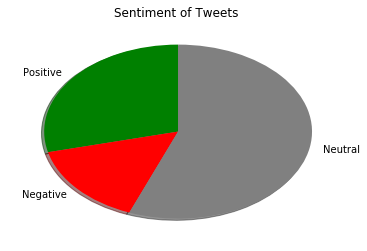

Positive:  17
Negative:  9
Neutral:  33


In [5]:
import re
import tweepy
import datetime
import time
import pandas as pd
import numpy as np
import csv
from tweepy import OAuthHandler
from textblob import TextBlob
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

from nltk.util import bigrams


cache_english_stopwords=stopwords.words('english')
#cache_en_tweet_stopwords=stopwords.words('english_tweet')

 
class TwitterClient(object):
    '''
    Generic Twitter Class for sentiment analysis.
    '''
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # keys and tokens from the Twitter Dev Console
        consumer_key = 'XXXXXXXXXXXXXXXXXXXXXXXX'
        consumer_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        access_token = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX'
        access_token_secret = 'XXXXXXXXXXXXXXXXXXXXXXXXX'
        
       
        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")
 
    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return (' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) )
 
    def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(self.clean_tweet(tweet))
     
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'
 
    def get_tweets(self, query, count = 100):
        '''
        Main function to fetch tweets and parse them.
        '''
        # empty list to store parsed tweets
        tweets = []
 
        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.search(q = query, count = count)
         
            # parsing tweets one by one
           
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = {}
                    
                 
                # saving text and sentiment of tweet
                parsed_tweet['text']       = tweet.text
                parsed_tweet['created_at'] = tweet.created_at
                parsed_tweet['sentiment']  = self.get_tweet_sentiment(tweet.text)
           
                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                    else:
                         tweets.append(parsed_tweet)             
 
            # return parsed tweets                
            return tweets
 
        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))
            
def write_sent_to_file(fname, df):
        try:
            df.to_csv(fname) 
        except IOError:
            print('An error occured trying to read the file.')
        except ValueError:
            print('Non-numeric data found in the file.')
        except ImportError:
            print('NO module found')
        except EOFError:
            print('Why did you do an EOF on me?')
        except KeyboardInterrupt:
            print('You cancelled the operation.')
            
            
            
def read_sent_file():
        now = datetime.datetime.now()
        ## count the data in the Sentiment column of the CSV file 
        with open("BTC_SNT.CSV", 'r') as data:
                counter = Counter()
                for row in csv.DictReader(data):
                     counter[row['sentiment']] += 1

                positive = counter['positive']
                negative = counter['negative']
                neutral  = counter['neutral']

        ## declare the variables for the pie chart, using the Counter variables for "sizes"
        colors = ['green', 'red', 'grey']
        sizes = [ positive, negative, neutral]
        labels = 'Positive', 'Negative', 'Neutral'
        ### use matplotlib to plot the chart
        plt.pie(
        x=sizes,
        shadow=True,
        colors=colors,
        labels=labels,
        startangle=90
        )
        
        plt.title("Sentiment of Tweets ")
        print(pd.Timestamp("today").strftime("%m/%d/%Y")) 
        plt.show()
        print("Positive: ", positive)
        print("Negative: ", negative)
        print("Neutral: ", neutral)
        
def main():
    # creating object of TwitterClient Class
    api = TwitterClient()
    # calling function to get tweets
    query = "Bitcoin"
    tweets = api.get_tweets(query , count = 100)
   
    
    df = pd.DataFrame(tweets)
    del(df['text'])
    df['created_at'] = pd.to_datetime(df['created_at'])
    df.index = df['created_at']
    del df['created_at']
    
    write_sent_to_file("BTC_SNT.CSV", df)
    read_sent_file()
 
if __name__ == "__main__":
    # calling main function
    main()